<a href="https://colab.research.google.com/github/fldiaz/NLP-examples/blob/main/1_fastext_bert_listados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
pip install fasttext


     |████████████████████████████████| 68 kB 3.1 MB/s 
  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3143487 sha256=fb9ff20783023b395304978d243170c5a46b0d1c6c0584c7ca21ff14b10bf713
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [4]:
pip install hdbscan

     |████████████████████████████████| 5.2 MB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2330863 sha256=55f19472505c34c2806d8fc66a29d66b4b8ff0fad2ac1db32792cc67176fea99
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99ef4a71e896b62f5161f2bc8a14c97a
Successfully built hdbscan


In [5]:
pip install umap-learn

     |████████████████████████████████| 88 kB 3.3 MB/s 
     |████████████████████████████████| 1.1 MB 36.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=8f57b32a17733149c2e802ebf773607fe95a595f62f415f527cc528fb0c6b9bd
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=843c6ac56b66b8adad48927677816e5f76c1416e6c139ff792419598a8619125
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [28]:
import umap
import hdbscan

from gensim.models import FastText
import pandas as pd
from sklearn.manifold import TSNE
import plotly.express as px
import matplotlib.pyplot as plt
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
from gensim.parsing.preprocessing import STOPWORDS, strip_tags,strip_numeric, remove_stopwords,strip_short, stem_text,strip_multiple_whitespaces
from gensim.parsing.preprocessing import preprocess_string
import fasttext

## Listas de deseos
#### De goodreads puedo extraer los nombres de los listados en donde cada usuario coloca el libro. Me trae 100 listados por libro.
#### El problema es que cómo son de texto libre, se pueden repetir o ser redundantes: son 68.211 listas diferentes, cada una con una cantidad de votos, es decir, la cantidad de lectores que usaron ese listado por cada libro.
#### Se busca agrupar aquellos listados que tienen similitud semántica y así obtener caracteristicas de cada libro basado en la opinión de los usuarios.




A popular idea in modern machine learning is to represent words by vectors. These vectors capture hidden information about a language, like word analogies or semantic. It is also used to improve performance of text classifiers.

In [7]:
#path='~/Riverside/'
path='/content/drive/MyDrive/Colab Notebooks/'

In [8]:
listados=pd.read_table(path+'listados.txt')

In [10]:
listados_simplificados=pd.read_table(path+'listado_simplificado.txt')#sacamos aquellos listados que tienen menos de 100 votos

In [12]:
listados_simplificados.shape

(3277, 1)

In [13]:
#Preprocesamiento: minúscula, sacamos multiples espacios, 
custom_filters=[lambda x:x.lower(),
                    strip_multiple_whitespaces,strip_tags,
                    strip_numeric,stem_text, 
                    strip_short]

In [29]:
#Esta función va a realizar el clustering por temática del listado. Es decir, los nombres de los listados con similitud semántica deber agruparse cerca
def clustering(embeddings, n_neighbors, n_components, d): #n_neighbors look at number of neighborhoods of each point when estimating the manifold structure of the data.
  umap_embeddings = umap.UMAP(n_neighbors=n_neighbors, min_dist=d,
                            n_components=n_components, 
                            metric='cosine').fit_transform(embeddings)
  cluster = hdbscan.HDBSCAN(min_cluster_size=15,#ver de cambiar según el resultado
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)
  # Prepare data for visualization
  umap_data = umap.UMAP(n_neighbors=n_neighbors, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings) #metric='hellinger'
  result = pd.DataFrame(umap_data, columns=['x', 'y'])
  result['labels'] = cluster.labels_
  return result
  

In [15]:
listados_list=listados_simplificados['to-read'].to_list()

In [16]:
#acá preprocesamos el texto, pero al final lo usamos en bruto
preproce=[]
for row in listados_list:
  new_row=preprocess_string(row, custom_filters)
  preproce.extend(new_row)

In [ ]:
preproce[:5]

### 1. Primer modelo: fasttext

#### Primero se quizo probar con fastext 
#### fastText can obtain vectors even for out-of-vocabulary (OOV) words, by summing up vectors for its component char-ngrams, provided at least one of the char-ngrams was present in the training data.
Tutorial:https://fasttext.cc/docs/en/unsupervised-tutorial.html

The skipgram model learns to predict a target word thanks to a nearby word. On the other hand, the cbow model predicts the target word according to its context. The context is represented as a bag of the words contained in a fixed size window around the target word.

In [18]:
###Learning word vectors on this data can now be achieved with a single command:
model = fasttext.train_unsupervised(path+'listados.txt', model='cbow', epoch=10, lr=0.15,  minn=2, maxn=10, dim=50)
#dim=la dimension de los vectores, como son palabras no es necesario que sean muy largo
#min max es cuan larga puede ser los subwords.
#epoch  The epoch parameter controls how many times the model will loop over your data. como el corpus no es muy grande, entonces lo dejamos 10 veces.

t returns all words in the vocabulary, sorted by decreasing frequency


In [19]:
len(model.words)

4106

In [20]:
#model.get_word_vector("childhood")
model.get_nearest_neighbors('childhood', 30)#ejemplo aquellas palabras cercanas a chilhood

[(0.8048824071884155, 'child'),
 (0.709597110748291, 'kids'),
 (0.688177227973938, 'old'),
 (0.6857762932777405, 'childrens'),
 (0.6809187531471252, 'told'),
 (0.6764212846755981, 'chapters'),
 (0.6676267981529236, 'toddler'),
 (0.6675223112106323, 'gold'),
 (0.6649518013000488, 'hollywood'),
 (0.655419647693634, 'wood'),
 (0.6552338600158691, 'brothers'),
 (0.6531575918197632, 'mothers'),
 (0.6463853120803833, 'excerpts'),
 (0.6433385014533997, 'children'),
 (0.6417973041534424, 'βιβλία'),
 (0.6390146017074585, 'chick'),
 (0.638531506061554, 'eleanor'),
 (0.6330210566520691, 'chilean'),
 (0.6320661902427673, 'lovers'),
 (0.6319848895072937, 'kid'),
 (0.6318193674087524, 'wordless'),
 (0.6285097002983093, 'charles'),
 (0.6183087229728699, 'famous'),
 (0.6178392767906189, 'elementary'),
 (0.6168542504310608, 'add'),
 (0.6163679361343384, 'clothbound'),
 (0.6161419153213501, 'others'),
 (0.6157504916191101, 'odd'),
 (0.6120573878288269, 'couples'),
 (0.6116763353347778, 'recipes')]

In [21]:
embedding=[model.get_word_vector(x) for x in model.words]#tomo los embeddings para hacer los clusters

In [22]:
model.get_word_vector('childhood')

array([-0.41166264,  0.2972194 , -0.06648589, -0.5373701 ,  0.3659654 ,
        0.4057635 , -0.07403656,  0.30949265,  0.58533996,  1.2107648 ,
       -0.45753404, -0.6157467 , -0.09820456,  0.66347766, -0.18548764,
        0.373873  , -0.70385516,  1.0166159 , -0.73155814, -0.9176061 ,
       -0.27030048,  0.80518353,  0.36949527, -0.92965704,  0.8133518 ,
        0.09094113, -0.9207566 ,  0.04908473,  0.04757013,  0.20621678,
        0.12679526,  0.0573629 , -0.03899962, -0.49212527,  0.40948027,
       -0.05777485,  0.662009  , -0.21198092, -0.27697286, -0.00589364,
       -0.653944  , -0.03152591,  0.26991355,  0.6489169 ,  0.21810375,
        0.3052208 , -0.40429688, -0.60187984, -0.8786633 , -0.07046135],
      dtype=float32)

In [56]:
model.get_word_vector('tbr').mean()

-0.017788833

In [25]:
model.get_word_vector('child').mean()

-0.08325965

In [ ]:
model.get_word_vector('adult').mean()

In [26]:
model.get_word_vector('young').mean()

0.033625208

In [30]:
#aplico la función de clustering

fastext_cluster=clustering(embedding, 50, 6, 0.1)#n_neighbors, n_components, d)min_dist

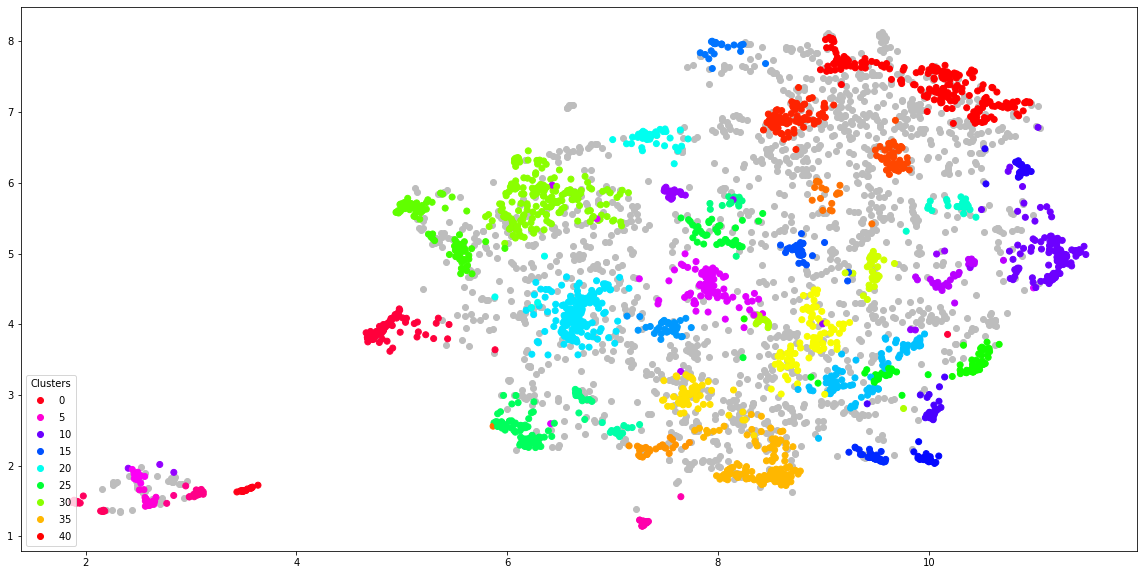

In [31]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = fastext_cluster.loc[fastext_cluster.labels == -1, :]
clustered = fastext_cluster.loc[fastext_cluster.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD')
scatter=plt.scatter(clustered.x, clustered.y, c=clustered.labels, cmap='hsv_r')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Clusters")
#ax.add_artist(legend1)
plt.show()

In [32]:
fig = px.scatter(
            
            clustered.x, clustered.y,
            color=clustered.labels,
            title="Plot for Listados",
            opacity=0.7,
            width=900,
            height=800,
        )
  
fig.show(renderer="colab")

In [33]:
fastext_cluster["listado"] = listados["to read"]


,x,y,labels,listado
6,10.178469,3.856853,1,library
22,4.813993,3.791175,1,audiobooks
155,4.886909,4.023997,1,favorite books
209,4.892974,4.018939,1,american lit
289,4.699907,3.815243,1,childhood
353,4.786963,3.742408,1,faves
366,4.677546,3.750549,1,mis libros
481,4.742930,3.850261,1,dystopia
526,5.326633,4.014192,1,روايات
540,4.969079,4.172038,1,psychological thriller


In [ ]:
#result.to_excel('resultados_fasttext2.xlsx')


In [ ]:
#fastext_cluster.to_excel('fastext_cluster.xlsx')

In [34]:
fastext_cluster.loc[fastext_cluster.labels==5]

,x,y,labels,listado
76,2.647005,1.451735,5,british
234,2.623565,1.472777,5,need to buy
296,2.604524,1.456367,5,noir
407,2.566736,1.500041,5,kobo
489,2.582163,1.475274,5,read in spanish
530,2.566990,1.425448,5,nonfiction to read
908,2.592931,1.484707,5,auto biography
929,2.611726,1.457467,5,christianity
1002,2.615960,1.465613,5,franceses
1065,2.553614,1.660400,5,theatre


### 2. Ahora probamos con BERT

BERT (Bidirectional Encoder Representations from Transformers) es un modelo de ML para NLP. Fue dearrollado en 2018 por google AI. Puede ser usado para resolver más de 11 tareas relacioandas con texto
BERT fue entrenado con Wikipedia (~2.5B words) and Google’s BooksCorpus (~800M words)
https://huggingface.co/blog/bert-101#241-how-do-transformers-work

In [41]:

#sentenceTransformers is a Python framework for state-of-the-art sentence, text and image embeddings. The initial work is described in our paper Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks.

SyntaxError: ignored

In [43]:
pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 3.6 MB/s 
     |████████████████████████████████| 4.0 MB 34.6 MB/s 
     |████████████████████████████████| 1.2 MB 33.3 MB/s 
     |████████████████████████████████| 77 kB 5.5 MB/s 
     |████████████████████████████████| 6.6 MB 28.0 MB/s 
     |████████████████████████████████| 596 kB 34.2 MB/s 
     |████████████████████████████████| 895 kB 34.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=27f547f8feae01073dea98972a30c05b476380ca5d5ff43819a5cea01162030f
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [44]:
from sentence_transformers import SentenceTransformer

sentence_model = SentenceTransformer("distilbert-base-nli-mean-tokens") #DistilBERT offers a lighter version of BERT; runs 60% faster while maintaining over 95% of BERT’s performance.


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [45]:
len(listados_list)

3277

In [46]:
embedding_bert = sentence_model.encode(listados_list, show_progress_bar=False)

In [47]:
bert_clustering=clustering(embedding_bert, 20, 10, 0.1)

In [1]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = bert_clustering.loc[bert_clustering.labels == -1, :]
clustered = bert_clustering.loc[bert_clustering.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD')
scatter=plt.scatter(clustered.x, clustered.y, c=clustered.labels, cmap='hsv_r')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Clusters")
#ax.add_artist(legend1)
plt.show()

NameError: ignored

In [49]:
bert_clustering["listado"] = listados_simplificados["to-read"]


In [50]:
bert_clustering.loc[bert_clustering.labels==40]

,x,y,labels,listado
68,11.543110,1.819789,40,art
195,11.911383,1.501340,40,architecture
217,12.005189,1.327423,40,urban-fantasy
249,11.344851,1.737814,40,design
289,11.263112,1.704518,40,photography
480,11.555640,1.813907,40,art-history
485,11.513671,1.832495,40,arte
713,11.221629,1.737521,40,graphic-design
754,11.505786,1.833327,40,arts
778,11.578486,1.772372,40,art-design


In [51]:
bert_clustering['labels'].value_counts()

-1     1288
 0      121
 49     112
 46      97
 48      97
 19      76
 44      71
 37      71
 25      66
 18      66
 17      64
 40      52
 22      52
 1       51
 47      51
 34      50
 32      41
 26      41
 36      36
 38      35
 28      35
 15      35
 45      34
 8       34
 42      33
 35      32
 12      30
 4       29
 23      28
 33      28
 7       27
 5       23
 11      23
 3       22
 20      22
 27      22
 43      21
 6       21
 21      21
 16      20
 41      20
 13      20
 9       20
 10      19
 30      19
 24      18
 29      18
 31      17
 39      16
 14      16
 2       16
Name: labels, dtype: int64

In [52]:
bert_clustering['labels'].max()

49

In [ ]:
bert_clustering.head()

In [ ]:
bert_clustering.groupby(['labels'], as_index = False).agg({'Doc': ' '.join})

In [ ]:
bert_clustering.to_excel('bert_clustering.xlsx')

In [53]:
bert_clustering=pd.read_excel(path+'bert_clustering_20_10.xlsx')

In [54]:
bert_clustering

,Unnamed: 0,x,y,labels,listado
0,0,10.551703,4.277760,39,currently-reading
1,1,12.542986,5.762572,49,fiction
2,2,11.898458,3.738369,70,favorites
3,3,12.287292,5.193840,47,classics
4,4,13.426038,4.928490,43,fantasy
...,...,...,...,...,...
3272,3272,15.864568,3.990891,15,mystery-and-thriller
3273,3273,12.185339,-0.046676,-1,armistead-maupin
3274,3274,10.605989,3.464582,37,owned-and-unread
3275,3275,12.364223,0.260535,-1,club-de-lectura


In [55]:
bert_clustering.loc[bert_clustering.labels==-1]

,Unnamed: 0,x,y,labels,listado
16,16,12.590105,4.608277,-1,classic
17,17,10.999142,2.031038,-1,series
19,19,9.495159,4.981740,-1,kindle
20,20,10.579797,5.719376,-1,audiobook
24,24,10.583629,5.287833,-1,literature
...,...,...,...,...,...
3257,3257,11.824098,0.848831,-1,recabar
3262,3262,12.548120,1.198100,-1,fante
3269,3269,11.139729,1.475340,-1,ks2
3273,3273,12.185339,-0.046676,-1,armistead-maupin
